In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = !unrar x "/content/drive/MyDrive/PILLS (1).rar"

In [ ]:
import os
from sklearn.model_selection import train_test_split

# =========================
# CONFIG
# =========================
DATASET_DIR = "/content/train"   # change this
OUTPUT_DIR = "/content/splits"
TEST_SIZE = 0.2
RANDOM_STATE = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)

# =========================
# STEP 1: GET & SORT CLASSES
# =========================
classes = sorted([
    d for d in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, d))
])

num_classes = len(classes)
print("Total classes:", num_classes)

# =========================
# STEP 2: WRITE classes.txt (ALPHABETICAL)
# =========================
with open(os.path.join(OUTPUT_DIR, "classes.txt"), "w") as f:
    for idx, cls in enumerate(classes, start=1):
        f.write(f"{idx} {cls}\n")

# =========================
# STEP 3: COLLECT & SORT IMAGES
# =========================
image_label_pairs = []

for idx, cls in enumerate(classes, start=1):
    class_dir = os.path.join(DATASET_DIR, cls)
    images = sorted(os.listdir(class_dir))   # alphabetical images
    for img in images:
        if img.lower().endswith((".jpg", ".png", ".jpeg")):
            rel_path = f"{cls}/{img}"
            image_label_pairs.append((rel_path, idx))

# Sort by image path globally
image_label_pairs.sort(key=lambda x: x[0])

print("Total images:", len(image_label_pairs))

# =========================
# STEP 4: STRATIFIED SPLIT
# =========================
train_data, test_data = train_test_split(
    image_label_pairs,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=[x[1] for x in image_label_pairs]
)

# Sort train & test alphabetically
train_data = sorted(train_data, key=lambda x: x[0])
test_data  = sorted(test_data, key=lambda x: x[0])

# =========================
# STEP 5: WRITE labels.txt (SORTED)
# =========================
with open(os.path.join(OUTPUT_DIR, "labels.txt"), "w") as f:
    for path, label in image_label_pairs:
        f.write(f"{label} {path}\n")

# =========================
# STEP 6: WRITE train.txt (SORTED)
# =========================
with open(os.path.join(OUTPUT_DIR, "train.txt"), "w") as f:
    for path, _ in train_data:
        f.write(f"{path}\n")

# =========================
# STEP 7: WRITE test.txt (SORTED)
# =========================
with open(os.path.join(OUTPUT_DIR, "test.txt"), "w") as f:
    for path, _ in test_data:
        f.write(f"{path}\n")

print("✔ All files generated in alphabetical order!")


Total classes: 20
Total images: 994
✔ All files generated in alphabetical order!


In [ ]:
import os

DATASET_DIR = "/content/train"   # change this
OUTPUT_FILE = "/content/labels.txt"

# Get class folders
classes = sorted([
    d for d in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, d))
])

with open(OUTPUT_FILE, "w") as f:
    for idx, cls in enumerate(classes, start=1):
        # convert apple_pie → Apple pie
        label = cls.replace("_", " ").title()
        f.write(f"{idx} {label}\n")

print("✔ labels.txt generated successfully")


✔ labels.txt generated successfully


In [ ]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [ ]:
%cd /content/train/

/content/train


In [ ]:
# Check the extracted dataset folder
!ls /content/train

'Amoxicillin 500 MG'	 'celecoxib 200 MG'		 'pitavastatin 1 MG'
'apixaban 2.5 MG'	 'duloxetine 30 MG'		 'prasugrel 10 MG'
'aprepitant 80 MG'	 'eltrombopag 25 MG'		 'Ramipril 5 MG'
'Atomoxetine 25 MG'	 'montelukast 10 MG'		 'saxagliptin 5 MG'
'benzonatate 100 MG'	 'mycophenolate mofetil 250 MG'  'sitagliptin 50 MG'
'Calcitriol 0.00025 MG'  'Oseltamivir 45 MG'		 'tadalafil 5 MG'
'carvedilol 3.125 MG'	 'pantoprazole 40 MG'


In [ ]:
os.listdir('/content/train')

['saxagliptin 5 MG',
 'aprepitant 80 MG',
 'Oseltamivir 45 MG',
 'pantoprazole 40 MG',
 'prasugrel 10 MG',
 'Atomoxetine 25 MG',
 'eltrombopag 25 MG',
 'duloxetine 30 MG',
 'benzonatate 100 MG',
 'montelukast 10 MG',
 'apixaban 2.5 MG',
 'Amoxicillin 500 MG',
 'Calcitriol 0.00025 MG',
 'tadalafil 5 MG',
 'sitagliptin 50 MG',
 'mycophenolate mofetil 250 MG',
 'Ramipril 5 MG',
 'carvedilol 3.125 MG',
 'celecoxib 200 MG',
 'pitavastatin 1 MG']

In [ ]:
os.listdir('/content/splits')

['labels.txt', 'classes.txt', 'test.txt', 'train.txt']

In [ ]:
!head /content/splits/train.txt

Amoxicillin 500 MG/Amoxicillin 500 MG (1) - Copy - Copy.jpg
Amoxicillin 500 MG/Amoxicillin 500 MG (1) - Copy.jpg
Amoxicillin 500 MG/Amoxicillin 500 MG (10) - Copy - Copy.jpg
Amoxicillin 500 MG/Amoxicillin 500 MG (10) - Copy.jpg
Amoxicillin 500 MG/Amoxicillin 500 MG (10).jpg
Amoxicillin 500 MG/Amoxicillin 500 MG (11) - Copy - Copy.jpg
Amoxicillin 500 MG/Amoxicillin 500 MG (11) - Copy.jpg
Amoxicillin 500 MG/Amoxicillin 500 MG (11).jpg
Amoxicillin 500 MG/Amoxicillin 500 MG (12) - Copy - Copy.jpg
Amoxicillin 500 MG/Amoxicillin 500 MG (12).jpg


In [ ]:
!head /content/splits/classes.txt

1 Amoxicillin 500 MG
2 Atomoxetine 25 MG
3 Calcitriol 0.00025 MG
4 Oseltamivir 45 MG
5 Ramipril 5 MG
6 apixaban 2.5 MG
7 aprepitant 80 MG
8 benzonatate 100 MG
9 carvedilol 3.125 MG
10 celecoxib 200 MG


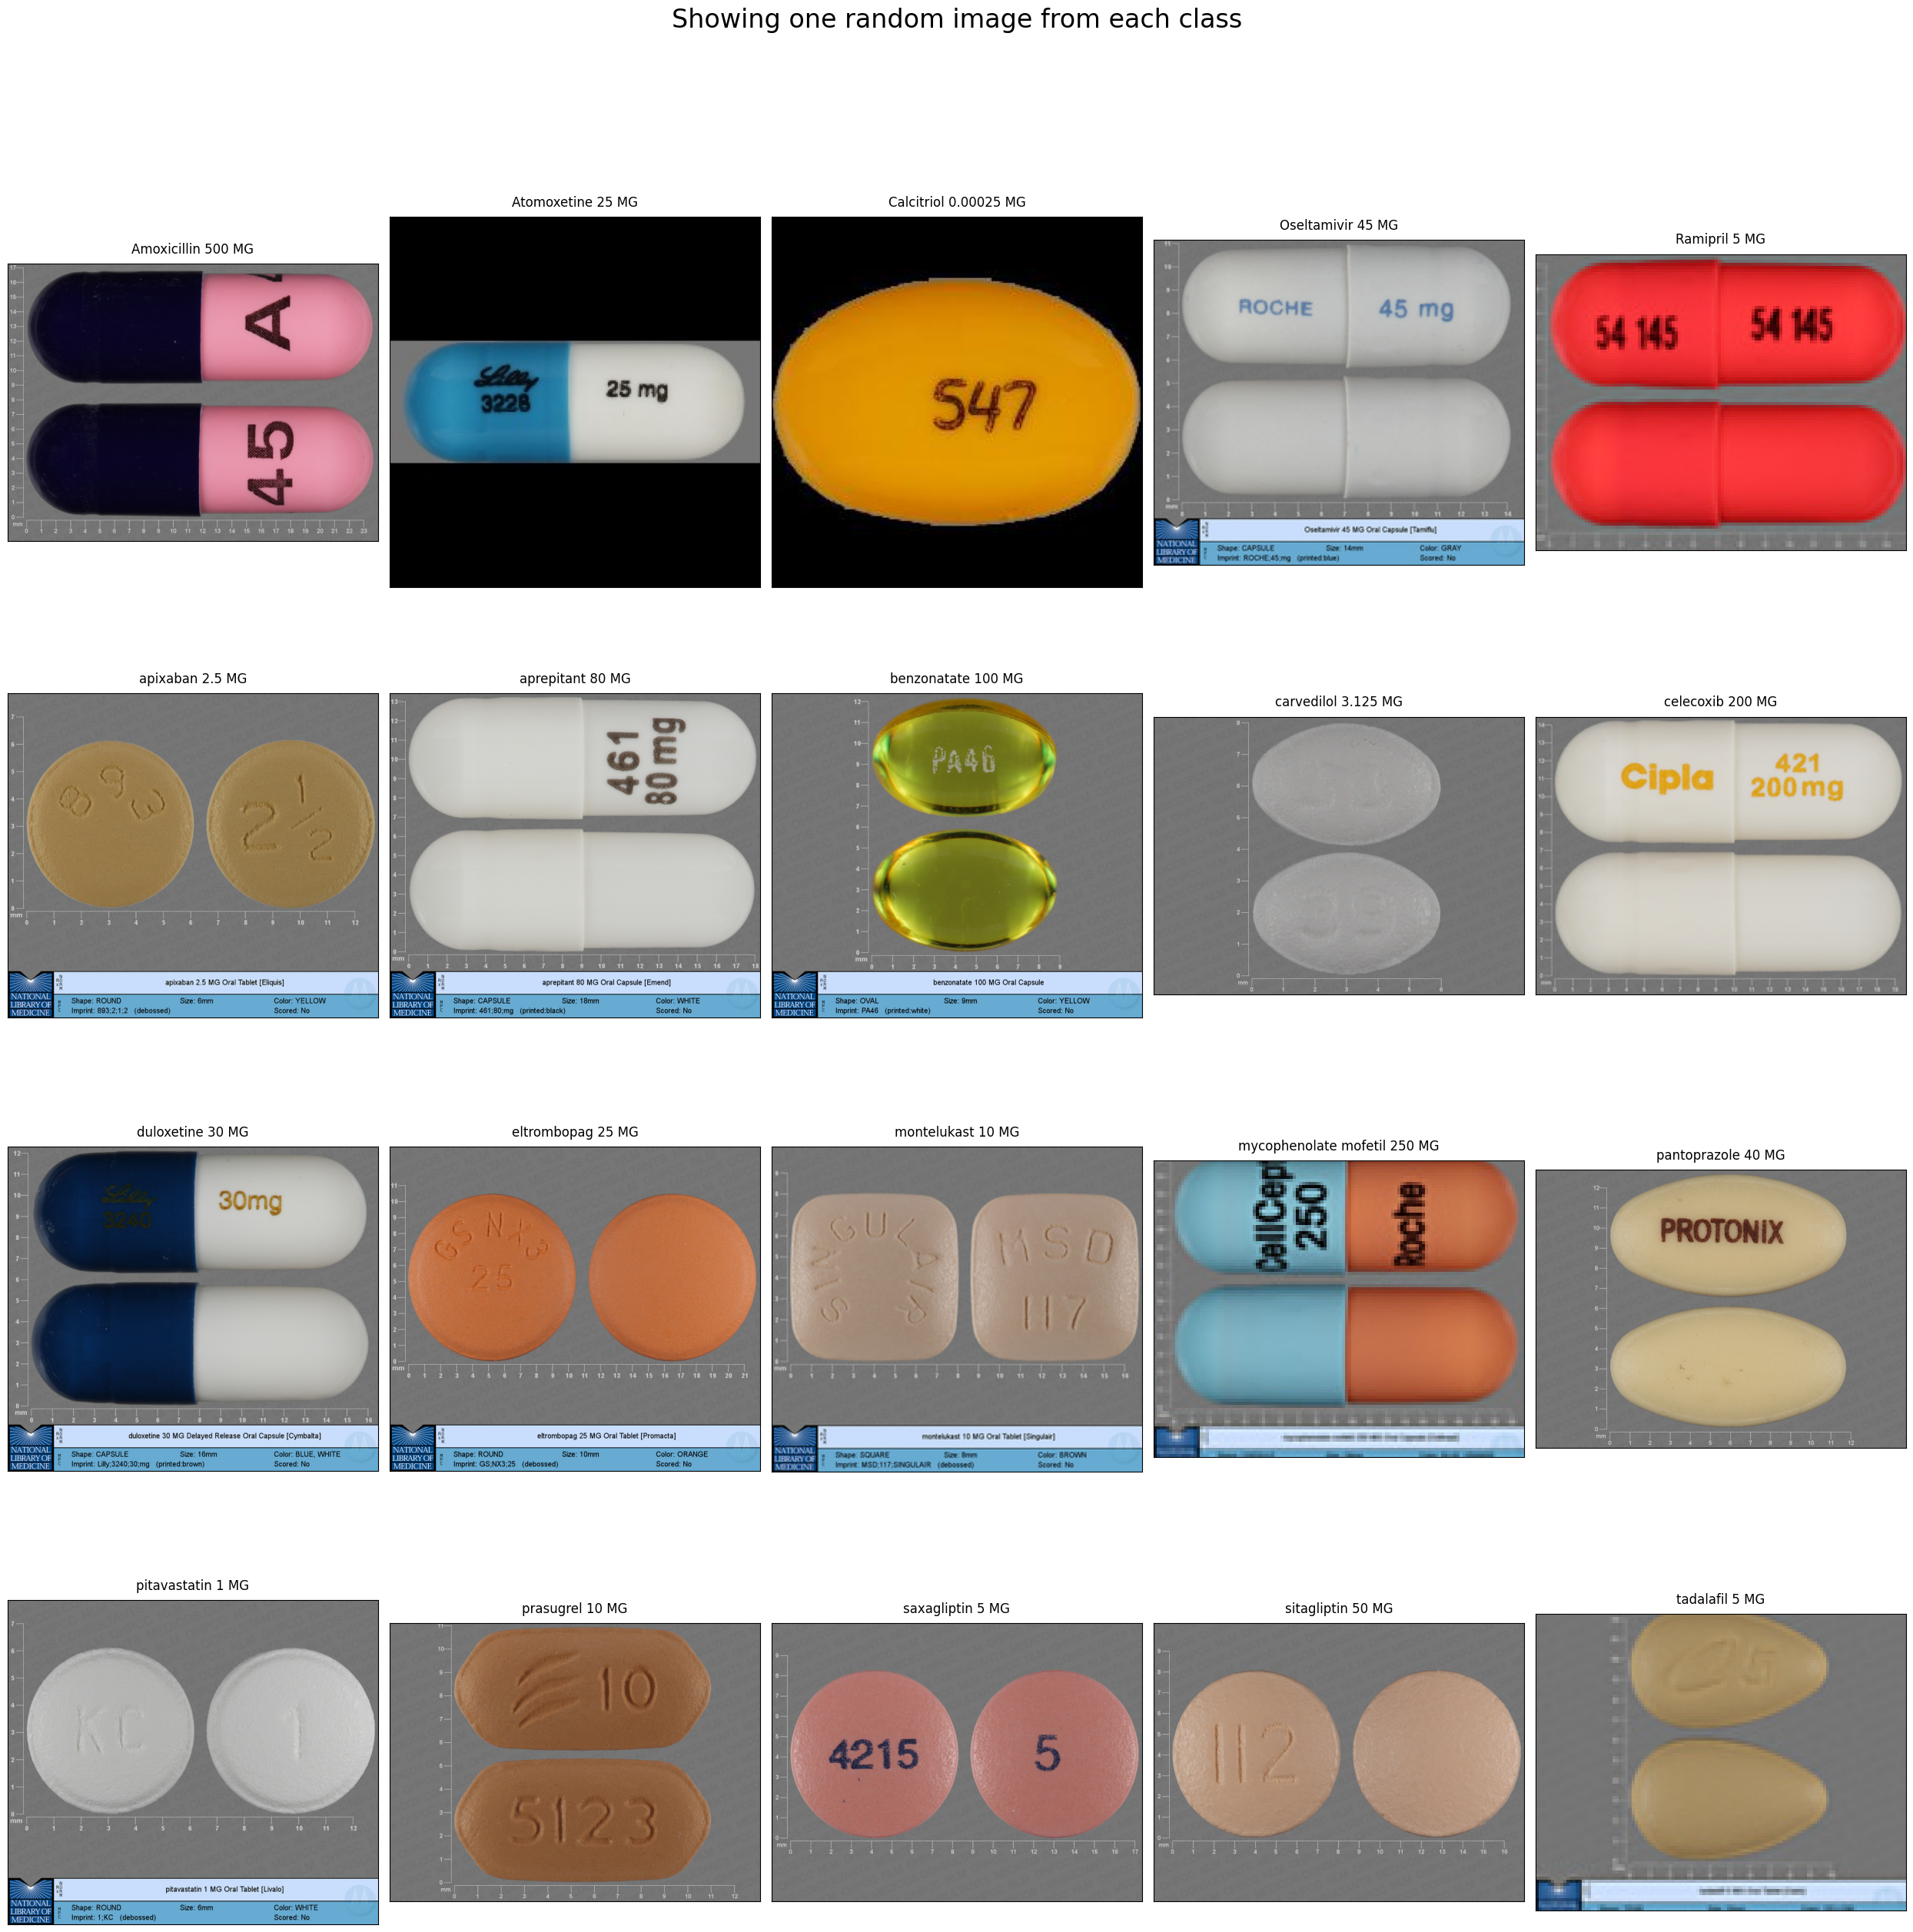

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 4
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "/content/train"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()


In [ ]:
def prepare_data(txt_file, src_dir, dest_dir):
    class_images = defaultdict(list)

    with open(txt_file, "r") as f:
        lines = f.readlines()

    for line in lines:
        cls, img = line.strip().split("/")
        class_images[cls].append(img)

    for cls in class_images:
        cls_dir = os.path.join(dest_dir, cls)
        os.makedirs(cls_dir, exist_ok=True)

        for img in class_images[cls]:
            copy(
                os.path.join(src_dir, cls, img),
                os.path.join(cls_dir, img)
            )

    print(f"✔ Data prepared at {dest_dir}")


In [ ]:
# Paths
BASE_DIR = "/content"
IMAGE_DIR = os.path.join(BASE_DIR, "train")

TRAIN_TXT = os.path.join(BASE_DIR, "/content/splits/train.txt")
TEST_TXT  = os.path.join(BASE_DIR, "/content/splits/test.txt")

TRAIN_DIR = "/content/working/train"
TEST_DIR  = "/content/working/test"

# Prepare folders
prepare_data(TRAIN_TXT, IMAGE_DIR, TRAIN_DIR)
prepare_data(TEST_TXT, IMAGE_DIR, TEST_DIR)


✔ Data prepared at /content/working/train
✔ Data prepared at /content/working/test


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

NUM_CLASSES = train_generator.num_classes
print("Number of classes:", NUM_CLASSES)


Found 795 images belonging to 20 classes.
Found 199 images belonging to 20 classes.
Number of classes: 20


In [ ]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,117,396 (92.00 MB)

 Trainable params: 529,684 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Single-cell end-to-end MobileNetV2 pipeline (loads images if X/y not present)
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import LabelEncoder

# ---------- USER CONFIG ----------
DATASET_DIR = "/content/working/train"    # <-- change to your dataset folder (subfolders per class)
TARGET_SIZE = (126, 126)
BATCH_SIZE = 32
RANDOM_STATE = 42
PHASE1_EPOCHS = 50
PHASE2_EPOCHS = 100
UNFREEZE_LAST_N = 50        # how many layers at the end to unfreeze for fine-tuning
MODEL_SAVE_PATH = "mobilenetv2_best.h5"
FINAL_SAVE_PATH = "mobilenetv2_final.h5"
# ---------------------------------

# If X,y,enc are already present in the notebook we reuse them; otherwise load from DATASET_DIR
if 'X' in globals() and 'y' in globals() and 'enc' in globals():
    print("Found existing X, y, enc in notebook — reusing them.")
    X = np.array(X).astype('float32')
    y = np.array(y).astype(int)
    enc = enc
else:
    # Validate dataset directory
    if not os.path.isdir(DATASET_DIR):
        raise FileNotFoundError(f"Dataset directory not found: {DATASET_DIR}\n"
                                "Create a folder with structure: dataset/<class_name>/*.jpg")
    print(f"Loading images from {DATASET_DIR} ... (this may take a while for large datasets)")

    # Use tf.keras utility to load dataset (returns a tf.data.Dataset)
    ds = tf.keras.utils.image_dataset_from_directory(
        DATASET_DIR,
        labels='inferred',
        label_mode='int',
        image_size=TARGET_SIZE,
        batch_size=None,   # load all as a single dataset so we can convert to numpy arrays
        shuffle=False
    )

    # Convert to numpy arrays
    X = []
    y = []
    for img, label in ds:
        X.append(img.numpy())
        y.append(int(label.numpy()))
    X = np.stack(X).astype('float32')
    y = np.array(y).astype(int)

    # Create and fit LabelEncoder (enc will map class names -> indices)
    class_names = sorted(next(os.walk(DATASET_DIR))[1])
    enc = LabelEncoder()
    enc.fit(class_names)
    # We loaded labels as ints already (image_dataset_from_directory uses alphabetical order),
    # but keep enc for downstream usage (enc.classes_ etc.)

print("Dataset shape:", X.shape, "Labels shape:", y.shape)
num_classes = len(np.unique(y))
print("Num classes:", num_classes)

# Normalize images (we will also use ImageDataGenerator rescale)
# Ensure pixel range is 0-255 before rescale step
if X.max() <= 1.0:
    # images may already be in [0,1]; scale to [0,255] then let datagen rescale to [0,1]
    X = (X * 255.).astype('float32')

# One-hot encode labels
y_cat = to_categorical(y, num_classes=num_classes)

# Train/test split (stratify uses 1-D numeric labels)
X_train, X_test, y_train, y_test, y_train_num, y_test_num = train_test_split(
    X, y_cat, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=0.3,
    brightness_range=[0.6, 1.4],
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
valid_generator = test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

# Class weights for imbalance
y_train_classes = np.array(y_train_num)
cw_arr = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weights = dict(enumerate(cw_arr))
print("Class weights:", class_weights)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=3e-6, verbose=1)
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, verbose=1)

# Build MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

# Phase 1: train only top layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Starting Phase 1 (train custom top layers)...")
history1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=PHASE1_EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# Phase 2: fine-tune
# Unfreeze last UNFREEZE_LAST_N layers (safer than unfreezing all)
if UNFREEZE_LAST_N <= 0:
    for layer in base_model.layers:
        layer.trainable = True
else:
    for layer in base_model.layers[:-UNFREEZE_LAST_N]:
        layer.trainable = False
    for layer in base_model.layers[-UNFREEZE_LAST_N:]:
        layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
print(f"Starting Phase 2 (fine-tune last {UNFREEZE_LAST_N} layers)...")
history2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=PHASE2_EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# Load best weights, evaluate and save final model
if os.path.exists(MODEL_SAVE_PATH):
    model.load_weights(MODEL_SAVE_PATH)
loss, acc = model.evaluate(valid_generator, verbose=1)
print(f"Validation Loss: {loss:.4f}  Validation Accuracy: {acc:.4f}")

model.save(FINAL_SAVE_PATH)
print(f"Saved final model to: {FINAL_SAVE_PATH}")

Loading images from /content/working/train ... (this may take a while for large datasets)
Found 795 files belonging to 20 classes.
Dataset shape: (795, 126, 126, 3) Labels shape: (795,)
Num classes: 20
Class weights: {0: np.float64(0.9928571428571429), 1: np.float64(0.896774193548387), 2: np.float64(0.9928571428571429), 3: np.float64(0.9928571428571429), 4: np.float64(1.3238095238095238), 5: np.float64(0.9586206896551724), 6: np.float64(0.7942857142857143), 7: np.float64(0.9586206896551724), 8: np.float64(0.9586206896551724), 9: np.float64(1.0692307692307692), 10: np.float64(0.9928571428571429), 11: np.float64(1.0296296296296297), 12: np.float64(1.0296296296296297), 13: np.float64(0.9266666666666666), 14: np.float64(1.0692307692307692), 15: np.float64(1.1583333333333334), 16: np.float64(0.9586206896551724), 17: np.float64(1.112), 18: np.float64(0.9586206896551724), 19: np.float64(1.0296296296296297)}


/tmp/ipython-input-3307346206.py:113: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 126, 126,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 63, 63,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 63, 63,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 63, 63,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 63, 63,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 63, 63,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 63, 63,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 63, 63,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 63, 63,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 63, 63,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 63, 63,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 63, 63,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,283,604 (8.71 MB)

 Trainable params: 2,249,492 (8.58 MB)

 Non-trainable params: 34,112 (133.25 KB)

Starting Phase 1 (train custom top layers)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.0807 - loss: 4.3688
Epoch 1: val_loss improved from inf to 1.73600, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.0838 - loss: 4.3338 - val_accuracy: 0.4393 - val_loss: 1.7360 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.2827 - loss: 2.4526
Epoch 2: val_loss improved from 1.73600 to 0.87696, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - accuracy: 0.2850 - loss: 2.4380 - val_accuracy: 0.7699 - val_loss: 0.8770 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4944 - loss: 1.4807
Epoch 3: val_loss improved from 0.87696 to 0.52012, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.4958 - loss: 1.4764 - val_accuracy: 0.8870 - val_loss: 0.5201 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6097 - loss: 1.1138
Epoch 4: val_loss improved from 0.52012 to 0.33364, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - accuracy: 0.6120 - loss: 1.1112 - val_accuracy: 0.9414 - val_loss: 0.3336 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7154 - loss: 0.9024
Epoch 5: val_loss improved from 0.33364 to 0.27379, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.7166 - loss: 0.8978 - val_accuracy: 0.9372 - val_loss: 0.2738 - learning_rate: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7770 - loss: 0.6949
Epoch 6: val_loss improved from 0.27379 to 0.25671, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.7765 - loss: 0.6955 - val_accuracy: 0.9372 - val_loss: 0.2567 - learning_rate: 0.0010
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7832 - loss: 0.6988
Epoch 7: val_loss improved from 0.25671 to 0.18966, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.7829 - loss: 0.6984 - val_accuracy: 0.9456 - val_loss: 0.1897 - learning_rate: 0.0010
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8314 - loss: 0.5138
Epoch 8: val_loss improved from 0.18966 to 0.16065, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - accuracy: 0.8299 - loss: 0.5178 - val_accuracy: 0.9540 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8462 - loss: 0.5114
Epoch 9: val_loss improved from 0.16065 to 0.16002, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.8456 - loss: 0.5120 - val_accuracy: 0.9498 - val_loss: 0.1600 - learning_rate: 0.0010
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8315 - loss: 0.4638
Epoch 10: val_loss did not improve from 0.16002
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.8324 - loss: 0.4635 - val_accuracy: 0.9414 - val_loss: 0.1601 - learning_rate: 0.0010
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8279 - loss: 0.4544
Epoch 11: val_loss improved from 0.16002 to 0.11874, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.8290 - loss: 0.4543 - val_accuracy: 0.9582 - val_loss: 0.1187 - learning_rate: 0.0010
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8467 - loss: 0.4379
Epoch 12: val_loss did not improve from 0.11874
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.8470 - loss: 0.4393 - val_accuracy: 0.9540 - val_loss: 0.1202 - learning_rate: 0.0010
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8607 - loss: 0.4047
Epoch 13: val_loss did not improve from 0.11874
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.8608 - loss: 0.4045 - val_accuracy: 0.9498 - val_loss: 0.1360 - learning_rate: 0.0010
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8836 - loss: 0.3659
Epoch 14: val_loss did not improve from 0.11874
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.8833 - loss: 0.3659 - val_accuracy: 0.9540 - val_loss: 0.1379 - learning_rate: 0.0010
Epoch 15/50
18/18 ━━━━━━━━━━━━━

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.8815 - loss: 0.3819 - val_accuracy: 0.9833 - val_loss: 0.1000 - learning_rate: 0.0010
Epoch 16/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8739 - loss: 0.3637
Epoch 16: val_loss did not improve from 0.10001
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.8743 - loss: 0.3620 - val_accuracy: 0.9665 - val_loss: 0.1033 - learning_rate: 0.0010
Epoch 17/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8909 - loss: 0.3142
Epoch 17: val_loss did not improve from 0.10001
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.8913 - loss: 0.3139 - val_accuracy: 0.9540 - val_loss: 0.1079 - learning_rate: 0.0010
Epoch 18/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8888 - loss: 0.3175
Epoch 18: val_loss improved from 0.10001 to 0.08528, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.8884 - loss: 0.3182 - val_accuracy: 0.9665 - val_loss: 0.0853 - learning_rate: 0.0010
Epoch 19/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9241 - loss: 0.2539
Epoch 19: val_loss improved from 0.08528 to 0.07184, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9234 - loss: 0.2549 - val_accuracy: 0.9833 - val_loss: 0.0718 - learning_rate: 0.0010
Epoch 20/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9127 - loss: 0.2595
Epoch 20: val_loss improved from 0.07184 to 0.06162, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - accuracy: 0.9123 - loss: 0.2591 - val_accuracy: 0.9958 - val_loss: 0.0616 - learning_rate: 0.0010
Epoch 21/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9193 - loss: 0.2564
Epoch 21: val_loss did not improve from 0.06162
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9192 - loss: 0.2560 - val_accuracy: 0.9791 - val_loss: 0.0706 - learning_rate: 0.0010
Epoch 22/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8891 - loss: 0.2845
Epoch 22: val_loss did not improve from 0.06162
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.8892 - loss: 0.2845 - val_accuracy: 0.9623 - val_loss: 0.0761 - learning_rate: 0.0010
Epoch 23/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9175 - loss: 0.2508
Epoch 23: val_loss improved from 0.06162 to 0.05001, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9177 - loss: 0.2501 - val_accuracy: 0.9958 - val_loss: 0.0500 - learning_rate: 0.0010
Epoch 24/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8983 - loss: 0.2927
Epoch 24: val_loss did not improve from 0.05001
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.8980 - loss: 0.2921 - val_accuracy: 0.9707 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 25/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9311 - loss: 0.2227
Epoch 25: val_loss improved from 0.05001 to 0.04973, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.9313 - loss: 0.2221 - val_accuracy: 0.9791 - val_loss: 0.0497 - learning_rate: 0.0010
Epoch 26/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9162 - loss: 0.2322
Epoch 26: val_loss improved from 0.04973 to 0.04860, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.9163 - loss: 0.2325 - val_accuracy: 0.9958 - val_loss: 0.0486 - learning_rate: 0.0010
Epoch 27/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9241 - loss: 0.2280
Epoch 27: val_loss did not improve from 0.04860
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.9238 - loss: 0.2284 - val_accuracy: 0.9791 - val_loss: 0.0667 - learning_rate: 0.0010
Epoch 28/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9082 - loss: 0.2424
Epoch 28: val_loss did not improve from 0.04860
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.9096 - loss: 0.2402 - val_accuracy: 0.9833 - val_loss: 0.0508 - learning_rate: 0.0010
Epoch 29/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9579 - loss: 0.1435
Epoch 29: val_loss did not improve from 0.04860
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9572 - loss: 0.1451 - val_accuracy: 0.9833 - val_loss: 0.0553 - learning_rate: 0.0010
Epoch 30/50
18/18 ━━━━━━━━━━━━━

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9360 - loss: 0.2122 - val_accuracy: 0.9958 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 31/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9638 - loss: 0.1424
Epoch 31: val_loss did not improve from 0.03837
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9634 - loss: 0.1434 - val_accuracy: 0.9791 - val_loss: 0.0536 - learning_rate: 0.0010
Epoch 32/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9291 - loss: 0.2001
Epoch 32: val_loss did not improve from 0.03837
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.9294 - loss: 0.1996 - val_accuracy: 0.9833 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 33/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9516 - loss: 0.1531
Epoch 33: val_loss did not improve from 0.03837
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9507 - loss: 0.1554 - val_accuracy: 0.9833 - val_loss: 0.0462 - learning_rate: 0.0010
Epoch 34/50
18/18 ━━━━━━━━━━━━━

18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5829 - loss: 1.4881 - val_accuracy: 0.9958 - val_loss: 0.0361 - learning_rate: 1.0000e-05
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5954 - loss: 1.3364
Epoch 2: val_loss improved from 0.03613 to 0.03270, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.5955 - loss: 1.3342 - val_accuracy: 1.0000 - val_loss: 0.0327 - learning_rate: 1.0000e-05
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6678 - loss: 1.0648
Epoch 3: val_loss improved from 0.03270 to 0.03021, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.6682 - loss: 1.0639 - val_accuracy: 1.0000 - val_loss: 0.0302 - learning_rate: 1.0000e-05
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7254 - loss: 0.9671
Epoch 4: val_loss improved from 0.03021 to 0.02853, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.7251 - loss: 0.9663 - val_accuracy: 1.0000 - val_loss: 0.0285 - learning_rate: 1.0000e-05
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7316 - loss: 0.8884
Epoch 5: val_loss improved from 0.02853 to 0.02700, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - accuracy: 0.7315 - loss: 0.8856 - val_accuracy: 1.0000 - val_loss: 0.0270 - learning_rate: 1.0000e-05
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7731 - loss: 0.8130
Epoch 6: val_loss improved from 0.02700 to 0.02524, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.7727 - loss: 0.8108 - val_accuracy: 1.0000 - val_loss: 0.0252 - learning_rate: 1.0000e-05
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7694 - loss: 0.6817
Epoch 7: val_loss improved from 0.02524 to 0.02405, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.7689 - loss: 0.6841 - val_accuracy: 1.0000 - val_loss: 0.0240 - learning_rate: 1.0000e-05
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8227 - loss: 0.5763
Epoch 8: val_loss improved from 0.02405 to 0.02300, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.8235 - loss: 0.5754 - val_accuracy: 1.0000 - val_loss: 0.0230 - learning_rate: 1.0000e-05
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8139 - loss: 0.6366
Epoch 9: val_loss improved from 0.02300 to 0.02184, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - accuracy: 0.8132 - loss: 0.6385 - val_accuracy: 1.0000 - val_loss: 0.0218 - learning_rate: 1.0000e-05
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8407 - loss: 0.4985
Epoch 10: val_loss improved from 0.02184 to 0.02097, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.8410 - loss: 0.5001 - val_accuracy: 1.0000 - val_loss: 0.0210 - learning_rate: 1.0000e-05
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8879 - loss: 0.4823
Epoch 11: val_loss improved from 0.02097 to 0.02038, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.8875 - loss: 0.4811 - val_accuracy: 1.0000 - val_loss: 0.0204 - learning_rate: 1.0000e-05
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8507 - loss: 0.5340
Epoch 12: val_loss improved from 0.02038 to 0.01983, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.8516 - loss: 0.5334 - val_accuracy: 1.0000 - val_loss: 0.0198 - learning_rate: 1.0000e-05
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8727 - loss: 0.4471
Epoch 13: val_loss improved from 0.01983 to 0.01932, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.8722 - loss: 0.4486 - val_accuracy: 1.0000 - val_loss: 0.0193 - learning_rate: 1.0000e-05
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8552 - loss: 0.4472
Epoch 14: val_loss improved from 0.01932 to 0.01888, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.8556 - loss: 0.4458 - val_accuracy: 1.0000 - val_loss: 0.0189 - learning_rate: 1.0000e-05
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8913 - loss: 0.3778
Epoch 15: val_loss improved from 0.01888 to 0.01857, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.8913 - loss: 0.3784 - val_accuracy: 1.0000 - val_loss: 0.0186 - learning_rate: 1.0000e-05
Epoch 16/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8411 - loss: 0.4573
Epoch 16: val_loss improved from 0.01857 to 0.01806, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.8423 - loss: 0.4552 - val_accuracy: 1.0000 - val_loss: 0.0181 - learning_rate: 1.0000e-05
Epoch 17/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9087 - loss: 0.3658
Epoch 17: val_loss improved from 0.01806 to 0.01757, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.9076 - loss: 0.3667 - val_accuracy: 1.0000 - val_loss: 0.0176 - learning_rate: 1.0000e-05
Epoch 18/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8547 - loss: 0.4597
Epoch 18: val_loss improved from 0.01757 to 0.01715, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.8553 - loss: 0.4581 - val_accuracy: 1.0000 - val_loss: 0.0171 - learning_rate: 1.0000e-05
Epoch 19/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9152 - loss: 0.3173
Epoch 19: val_loss improved from 0.01715 to 0.01709, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9148 - loss: 0.3179 - val_accuracy: 1.0000 - val_loss: 0.0171 - learning_rate: 1.0000e-05
Epoch 20/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8778 - loss: 0.3668
Epoch 20: val_loss improved from 0.01709 to 0.01691, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - accuracy: 0.8782 - loss: 0.3663 - val_accuracy: 1.0000 - val_loss: 0.0169 - learning_rate: 1.0000e-05
Epoch 21/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8862 - loss: 0.3445
Epoch 21: val_loss improved from 0.01691 to 0.01626, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.8866 - loss: 0.3438 - val_accuracy: 1.0000 - val_loss: 0.0163 - learning_rate: 1.0000e-05
Epoch 22/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9172 - loss: 0.2971
Epoch 22: val_loss improved from 0.01626 to 0.01594, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9173 - loss: 0.2974 - val_accuracy: 1.0000 - val_loss: 0.0159 - learning_rate: 1.0000e-05
Epoch 23/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9359 - loss: 0.2667
Epoch 23: val_loss improved from 0.01594 to 0.01546, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.9355 - loss: 0.2675 - val_accuracy: 1.0000 - val_loss: 0.0155 - learning_rate: 1.0000e-05
Epoch 24/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9130 - loss: 0.3218
Epoch 24: val_loss improved from 0.01546 to 0.01511, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.9132 - loss: 0.3213 - val_accuracy: 1.0000 - val_loss: 0.0151 - learning_rate: 1.0000e-05
Epoch 25/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9053 - loss: 0.2755
Epoch 25: val_loss improved from 0.01511 to 0.01481, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9061 - loss: 0.2750 - val_accuracy: 0.9958 - val_loss: 0.0148 - learning_rate: 1.0000e-05
Epoch 26/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9205 - loss: 0.2875
Epoch 26: val_loss improved from 0.01481 to 0.01465, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9205 - loss: 0.2864 - val_accuracy: 0.9958 - val_loss: 0.0147 - learning_rate: 1.0000e-05
Epoch 27/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9158 - loss: 0.2409
Epoch 27: val_loss improved from 0.01465 to 0.01445, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.9160 - loss: 0.2418 - val_accuracy: 0.9958 - val_loss: 0.0145 - learning_rate: 1.0000e-05
Epoch 28/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9336 - loss: 0.2370
Epoch 28: val_loss improved from 0.01445 to 0.01420, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.9336 - loss: 0.2372 - val_accuracy: 0.9958 - val_loss: 0.0142 - learning_rate: 1.0000e-05
Epoch 29/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9267 - loss: 0.2094
Epoch 29: val_loss improved from 0.01420 to 0.01406, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9264 - loss: 0.2105 - val_accuracy: 0.9958 - val_loss: 0.0141 - learning_rate: 1.0000e-05
Epoch 30/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9416 - loss: 0.2060
Epoch 30: val_loss improved from 0.01406 to 0.01375, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.9415 - loss: 0.2066 - val_accuracy: 0.9958 - val_loss: 0.0138 - learning_rate: 1.0000e-05
Epoch 31/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9256 - loss: 0.2798
Epoch 31: val_loss improved from 0.01375 to 0.01339, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.9258 - loss: 0.2778 - val_accuracy: 0.9958 - val_loss: 0.0134 - learning_rate: 1.0000e-05
Epoch 32/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9342 - loss: 0.2208
Epoch 32: val_loss improved from 0.01339 to 0.01282, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9343 - loss: 0.2209 - val_accuracy: 0.9958 - val_loss: 0.0128 - learning_rate: 1.0000e-05
Epoch 33/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9372 - loss: 0.2318
Epoch 33: val_loss improved from 0.01282 to 0.01260, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.9373 - loss: 0.2310 - val_accuracy: 0.9958 - val_loss: 0.0126 - learning_rate: 1.0000e-05
Epoch 34/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9558 - loss: 0.1925
Epoch 34: val_loss improved from 0.01260 to 0.01249, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.9553 - loss: 0.1933 - val_accuracy: 0.9958 - val_loss: 0.0125 - learning_rate: 1.0000e-05
Epoch 35/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9374 - loss: 0.2206
Epoch 35: val_loss improved from 0.01249 to 0.01225, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.9373 - loss: 0.2212 - val_accuracy: 0.9958 - val_loss: 0.0122 - learning_rate: 1.0000e-05
Epoch 36/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9451 - loss: 0.1767
Epoch 36: val_loss improved from 0.01225 to 0.01206, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.9447 - loss: 0.1770 - val_accuracy: 0.9958 - val_loss: 0.0121 - learning_rate: 1.0000e-05
Epoch 37/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9053 - loss: 0.2345
Epoch 37: val_loss improved from 0.01206 to 0.01198, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.9057 - loss: 0.2347 - val_accuracy: 1.0000 - val_loss: 0.0120 - learning_rate: 1.0000e-05
Epoch 38/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9330 - loss: 0.1910
Epoch 38: val_loss improved from 0.01198 to 0.01169, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.9332 - loss: 0.1906 - val_accuracy: 1.0000 - val_loss: 0.0117 - learning_rate: 1.0000e-05
Epoch 39/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9638 - loss: 0.1331
Epoch 39: val_loss improved from 0.01169 to 0.01114, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9634 - loss: 0.1340 - val_accuracy: 1.0000 - val_loss: 0.0111 - learning_rate: 1.0000e-05
Epoch 40/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9325 - loss: 0.2375
Epoch 40: val_loss improved from 0.01114 to 0.01095, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9333 - loss: 0.2359 - val_accuracy: 1.0000 - val_loss: 0.0109 - learning_rate: 1.0000e-05
Epoch 41/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9367 - loss: 0.2034
Epoch 41: val_loss improved from 0.01095 to 0.01093, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.9370 - loss: 0.2024 - val_accuracy: 0.9958 - val_loss: 0.0109 - learning_rate: 1.0000e-05
Epoch 42/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9532 - loss: 0.1829
Epoch 42: val_loss did not improve from 0.01093
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.9533 - loss: 0.1831 - val_accuracy: 0.9958 - val_loss: 0.0110 - learning_rate: 1.0000e-05
Epoch 43/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9513 - loss: 0.1794
Epoch 43: val_loss improved from 0.01093 to 0.01075, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9516 - loss: 0.1786 - val_accuracy: 0.9958 - val_loss: 0.0107 - learning_rate: 1.0000e-05
Epoch 44/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9539 - loss: 0.1589
Epoch 44: val_loss improved from 0.01075 to 0.01030, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9540 - loss: 0.1579 - val_accuracy: 1.0000 - val_loss: 0.0103 - learning_rate: 1.0000e-05
Epoch 45/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9315 - loss: 0.1900
Epoch 45: val_loss improved from 0.01030 to 0.01016, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.9321 - loss: 0.1896 - val_accuracy: 1.0000 - val_loss: 0.0102 - learning_rate: 1.0000e-05
Epoch 46/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9457 - loss: 0.1683
Epoch 46: val_loss did not improve from 0.01016
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9462 - loss: 0.1671 - val_accuracy: 0.9958 - val_loss: 0.0103 - learning_rate: 1.0000e-05
Epoch 47/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9392 - loss: 0.1716
Epoch 47: val_loss did not improve from 0.01016
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9396 - loss: 0.1708 - val_accuracy: 0.9958 - val_loss: 0.0102 - learning_rate: 1.0000e-05
Epoch 48/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9578 - loss: 0.1707
Epoch 48: val_loss improved from 0.01016 to 0.01000, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.9578 - loss: 0.1709 - val_accuracy: 1.0000 - val_loss: 0.0100 - learning_rate: 1.0000e-05
Epoch 49/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9516 - loss: 0.1792
Epoch 49: val_loss improved from 0.01000 to 0.00979, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9520 - loss: 0.1777 - val_accuracy: 1.0000 - val_loss: 0.0098 - learning_rate: 1.0000e-05
Epoch 50/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9532 - loss: 0.1488
Epoch 50: val_loss improved from 0.00979 to 0.00974, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.9533 - loss: 0.1486 - val_accuracy: 1.0000 - val_loss: 0.0097 - learning_rate: 1.0000e-05
Epoch 51/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9523 - loss: 0.1311
Epoch 51: val_loss improved from 0.00974 to 0.00955, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9519 - loss: 0.1323 - val_accuracy: 1.0000 - val_loss: 0.0096 - learning_rate: 1.0000e-05
Epoch 52/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9558 - loss: 0.1368
Epoch 52: val_loss improved from 0.00955 to 0.00930, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.9561 - loss: 0.1363 - val_accuracy: 1.0000 - val_loss: 0.0093 - learning_rate: 1.0000e-05
Epoch 53/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9745 - loss: 0.0937
Epoch 53: val_loss improved from 0.00930 to 0.00903, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.9739 - loss: 0.0952 - val_accuracy: 1.0000 - val_loss: 0.0090 - learning_rate: 1.0000e-05
Epoch 54/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9693 - loss: 0.1032
Epoch 54: val_loss improved from 0.00903 to 0.00889, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9685 - loss: 0.1051 - val_accuracy: 1.0000 - val_loss: 0.0089 - learning_rate: 1.0000e-05
Epoch 55/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9338 - loss: 0.1839
Epoch 55: val_loss improved from 0.00889 to 0.00869, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9343 - loss: 0.1828 - val_accuracy: 1.0000 - val_loss: 0.0087 - learning_rate: 1.0000e-05
Epoch 56/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9713 - loss: 0.1062
Epoch 56: val_loss improved from 0.00869 to 0.00834, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.9712 - loss: 0.1065 - val_accuracy: 1.0000 - val_loss: 0.0083 - learning_rate: 1.0000e-05
Epoch 57/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9608 - loss: 0.1157
Epoch 57: val_loss improved from 0.00834 to 0.00814, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.9611 - loss: 0.1157 - val_accuracy: 1.0000 - val_loss: 0.0081 - learning_rate: 1.0000e-05
Epoch 58/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9745 - loss: 0.1149
Epoch 58: val_loss improved from 0.00814 to 0.00808, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9740 - loss: 0.1153 - val_accuracy: 1.0000 - val_loss: 0.0081 - learning_rate: 1.0000e-05
Epoch 59/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9813 - loss: 0.0948
Epoch 59: val_loss did not improve from 0.00808
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.9812 - loss: 0.0950 - val_accuracy: 1.0000 - val_loss: 0.0082 - learning_rate: 1.0000e-05
Epoch 60/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9725 - loss: 0.0952
Epoch 60: val_loss did not improve from 0.00808
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.9723 - loss: 0.0961 - val_accuracy: 1.0000 - val_loss: 0.0081 - learning_rate: 1.0000e-05
Epoch 61/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9518 - loss: 0.1464
Epoch 61: val_loss improved from 0.00808 to 0.00801, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9519 - loss: 0.1460 - val_accuracy: 1.0000 - val_loss: 0.0080 - learning_rate: 1.0000e-05
Epoch 62/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9637 - loss: 0.1125
Epoch 62: val_loss improved from 0.00801 to 0.00758, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.9637 - loss: 0.1128 - val_accuracy: 1.0000 - val_loss: 0.0076 - learning_rate: 1.0000e-05
Epoch 63/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9665 - loss: 0.1067
Epoch 63: val_loss improved from 0.00758 to 0.00749, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.9656 - loss: 0.1091 - val_accuracy: 1.0000 - val_loss: 0.0075 - learning_rate: 1.0000e-05
Epoch 64/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9676 - loss: 0.0923
Epoch 64: val_loss improved from 0.00749 to 0.00747, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9675 - loss: 0.0924 - val_accuracy: 1.0000 - val_loss: 0.0075 - learning_rate: 1.0000e-05
Epoch 65/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9728 - loss: 0.0916
Epoch 65: val_loss did not improve from 0.00747
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9722 - loss: 0.0934 - val_accuracy: 1.0000 - val_loss: 0.0075 - learning_rate: 1.0000e-05
Epoch 66/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9615 - loss: 0.1072
Epoch 66: val_loss did not improve from 0.00747
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.9623 - loss: 0.1059 - val_accuracy: 1.0000 - val_loss: 0.0076 - learning_rate: 1.0000e-05
Epoch 67/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9646 - loss: 0.1112
Epoch 67: val_loss improved from 0.00747 to 0.00744, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.9645 - loss: 0.1110 - val_accuracy: 1.0000 - val_loss: 0.0074 - learning_rate: 1.0000e-05
Epoch 68/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9631 - loss: 0.1172
Epoch 68: ReduceLROnPlateau reducing learning rate to 3e-06.

Epoch 68: val_loss improved from 0.00744 to 0.00740, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.9630 - loss: 0.1174 - val_accuracy: 1.0000 - val_loss: 0.0074 - learning_rate: 1.0000e-05
Epoch 69/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9691 - loss: 0.1117
Epoch 69: val_loss improved from 0.00740 to 0.00732, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.9688 - loss: 0.1126 - val_accuracy: 1.0000 - val_loss: 0.0073 - learning_rate: 3.0000e-06
Epoch 70/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9626 - loss: 0.1190
Epoch 70: val_loss improved from 0.00732 to 0.00727, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9627 - loss: 0.1180 - val_accuracy: 1.0000 - val_loss: 0.0073 - learning_rate: 3.0000e-06
Epoch 71/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9695 - loss: 0.0993
Epoch 71: val_loss improved from 0.00727 to 0.00726, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - accuracy: 0.9694 - loss: 0.0994 - val_accuracy: 1.0000 - val_loss: 0.0073 - learning_rate: 3.0000e-06
Epoch 72/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9664 - loss: 0.1101
Epoch 72: val_loss improved from 0.00726 to 0.00723, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9664 - loss: 0.1100 - val_accuracy: 1.0000 - val_loss: 0.0072 - learning_rate: 3.0000e-06
Epoch 73/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9248 - loss: 0.1973
Epoch 73: val_loss improved from 0.00723 to 0.00720, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9268 - loss: 0.1929 - val_accuracy: 1.0000 - val_loss: 0.0072 - learning_rate: 3.0000e-06
Epoch 74/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9548 - loss: 0.1493
Epoch 74: val_loss improved from 0.00720 to 0.00718, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.9553 - loss: 0.1486 - val_accuracy: 1.0000 - val_loss: 0.0072 - learning_rate: 3.0000e-06
Epoch 75/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9741 - loss: 0.0906
Epoch 75: val_loss did not improve from 0.00718
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.9739 - loss: 0.0910 - val_accuracy: 1.0000 - val_loss: 0.0072 - learning_rate: 3.0000e-06
Epoch 76/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9620 - loss: 0.1003
Epoch 76: val_loss did not improve from 0.00718
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9620 - loss: 0.1009 - val_accuracy: 1.0000 - val_loss: 0.0072 - learning_rate: 3.0000e-06
Epoch 77/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9754 - loss: 0.0836
Epoch 77: val_loss did not improve from 0.00718
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.9754 - loss: 0.0842 - val_accuracy: 1.0000 - val_loss: 0.0072 - learning_rate: 3.0000e-06
Epoch 78/100

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.9843 - loss: 0.0737 - val_accuracy: 1.0000 - val_loss: 0.0072 - learning_rate: 3.0000e-06
Epoch 80/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9833 - loss: 0.0782
Epoch 80: val_loss improved from 0.00717 to 0.00715, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9827 - loss: 0.0792 - val_accuracy: 1.0000 - val_loss: 0.0072 - learning_rate: 3.0000e-06
Epoch 81/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9690 - loss: 0.1087
Epoch 81: val_loss did not improve from 0.00715
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.9690 - loss: 0.1083 - val_accuracy: 1.0000 - val_loss: 0.0072 - learning_rate: 3.0000e-06
Epoch 82/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9785 - loss: 0.0871
Epoch 82: val_loss did not improve from 0.00715
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9783 - loss: 0.0870 - val_accuracy: 1.0000 - val_loss: 0.0072 - learning_rate: 3.0000e-06
Epoch 83/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9818 - loss: 0.0728
Epoch 83: val_loss did not improve from 0.00715
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.9816 - loss: 0.0734 - val_accuracy: 1.0000 - val_loss: 0.0072 - learning_rate: 3.0000e-06
Epoch 84/100

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9736 - loss: 0.0893 - val_accuracy: 1.0000 - val_loss: 0.0071 - learning_rate: 3.0000e-06
Epoch 85/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9517 - loss: 0.1348
Epoch 85: val_loss improved from 0.00713 to 0.00703, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9526 - loss: 0.1332 - val_accuracy: 1.0000 - val_loss: 0.0070 - learning_rate: 3.0000e-06
Epoch 86/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9683 - loss: 0.1022
Epoch 86: val_loss improved from 0.00703 to 0.00701, saving model to mobilenetv2_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.9680 - loss: 0.1028 - val_accuracy: 1.0000 - val_loss: 0.0070 - learning_rate: 3.0000e-06
Epoch 87/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9683 - loss: 0.1090
Epoch 87: val_loss did not improve from 0.00701
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.9686 - loss: 0.1080 - val_accuracy: 1.0000 - val_loss: 0.0070 - learning_rate: 3.0000e-06
Epoch 88/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9612 - loss: 0.1255
Epoch 88: val_loss did not improve from 0.00701
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9611 - loss: 0.1254 - val_accuracy: 1.0000 - val_loss: 0.0071 - learning_rate: 3.0000e-06
Epoch 89/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9794 - loss: 0.0740
Epoch 89: val_loss did not improve from 0.00701
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9791 - loss: 0.0743 - val_accuracy: 1.0000 - val_loss: 0.0071 - learning_rate: 3.0000e-06
Epoch 90/100

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9646 - loss: 0.1054 - val_accuracy: 1.0000 - val_loss: 0.0070 - learning_rate: 3.0000e-06
Epoch 94/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9668 - loss: 0.0936
Epoch 94: val_loss did not improve from 0.00700
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9675 - loss: 0.0929 - val_accuracy: 1.0000 - val_loss: 0.0070 - learning_rate: 3.0000e-06
Epoch 95/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9770 - loss: 0.0796
Epoch 95: val_loss did not improve from 0.00700
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9769 - loss: 0.0799 - val_accuracy: 1.0000 - val_loss: 0.0071 - learning_rate: 3.0000e-06
Epoch 96/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9843 - loss: 0.0654
Epoch 96: val_loss did not improve from 0.00700
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9839 - loss: 0.0660 - val_accuracy: 1.0000 - val_loss: 0.0071 - learning_rate: 3.0000e-06
Epoch 97/100

Validation Loss: 0.0070  Validation Accuracy: 1.0000
Saved final model to: mobilenetv2_final.h5


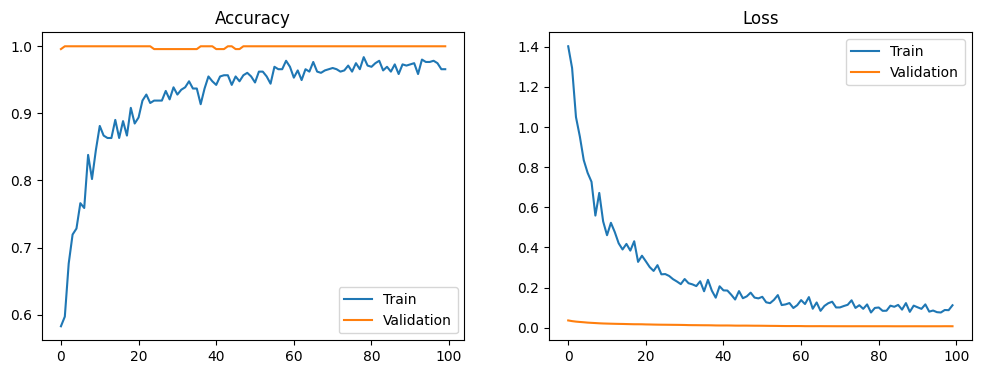

In [ ]:
def plot_metrics(history):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history2.history['accuracy'])
    plt.plot(history2.history['val_accuracy'])
    plt.title("Accuracy")
    plt.legend(["Train","Validation"])

    plt.subplot(1,2,2)
    plt.plot(history2.history['loss'])
    plt.plot(history2.history['val_loss'])
    plt.title("Loss")
    plt.legend(["Train","Validation"])

    plt.show()

plot_metrics(history2)


In [ ]:
# Load class names from classes.txt
classes_file = "/content/splits/classes.txt"

class_names = []
with open(classes_file, "r") as f:
    for line in f:
        _, name = line.strip().split(" ", 1)
        class_names.append(name)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_pill(model, img_path):
    img = image.load_img(img_path, target_size=(126, 126))
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = img_arr / 255.0

    preds = model.predict(img_arr)
    idx = np.argmax(preds)

    print("Predicted Pill:", class_names[idx])

    plt.imshow(img)
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted Pill: Amoxicillin 500 MG


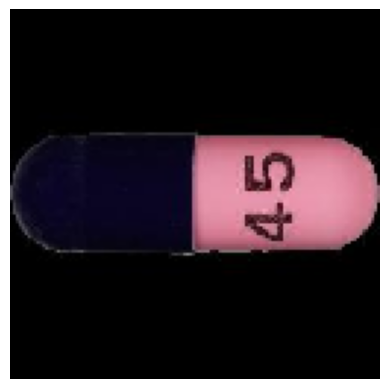

In [ ]:
predict_pill(model, "/content/train/Amoxicillin 500 MG/Amoxicillin 500 MG (1) - Copy - Copy.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Pill: Atomoxetine 25 MG


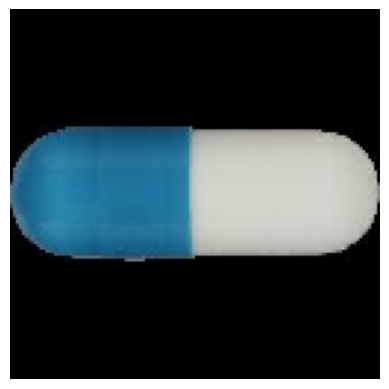

In [ ]:
predict_pill(model, "/content/train/Atomoxetine 25 MG/0002-3228_0_1 - Copy (2).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Pill: Ramipril 5 MG


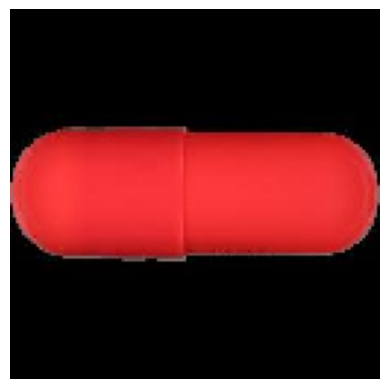

In [ ]:
predict_pill(model, "/content/train/Ramipril 5 MG/Ramipril 5 MG (1) - Copy.jpg")